# Notes

# Imports

In [28]:
import numpy as np
np.set_printoptions(suppress=True)
import h5py
import pandas as pd
import time
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
%matplotlib widget
%load_ext autoreload
%autoreload 2

# --- import functions for computing kinematic variables --- #
sys.path.append('../tracking_code/lib/')
from kinematics import compute_pec_pec_distance, compute_thetaW_and_thetaL
from tracking import contiguous_regions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load the tracking data

In [10]:
main_load_folder = '/media/liam/hd1/fighting_data/tracking_results/'


loadpaths = glob.glob(os.path.join(main_load_folder, '*results.h5'))
loadpaths.sort()

# parse the exp names
expNames = [path.split('/')[-1][:23] for path in loadpaths]

smooth_trajectories = []
expNumFrames = []
for path in loadpaths:
    with h5py.File(path, 'r') as hf:
        tracks_3D_smooth = hf['tracks_3D_smooth'][:]
    print(tracks_3D_smooth.shape)
    smooth_trajectories.append(tracks_3D_smooth)
    expNumFrames.append(tracks_3D_smooth.shape[0])
    

# -----------------------------#
# load other useful information
    
other_info_loadpath = os.path.join(main_load_folder, 'winners_losers_inconclusive.h5')
with h5py.File(other_info_loadpath, 'r') as hf:
    winner_idxs = hf['winner_idxs'][:]
    loser_idxs = hf['loser_idxs'][:]
    conclusive_winner_loser = hf['conclusive_winner_loser'][:]
    

(971756, 2, 3, 3)
(769848, 2, 3, 3)
(501943, 2, 3, 3)
(517000, 2, 3, 3)
(463997, 2, 3, 3)
(730119, 2, 3, 3)
(495610, 2, 3, 3)
(601226, 2, 3, 3)
(537880, 2, 3, 3)
(1032353, 2, 3, 3)
(561010, 2, 3, 3)
(556428, 2, 3, 3)
(746434, 2, 3, 3)
(1248577, 2, 3, 3)
(596607, 2, 3, 3)
(588962, 2, 3, 3)
(689100, 2, 3, 3)
(497635, 2, 3, 3)
(1695643, 2, 3, 3)
(798382, 2, 3, 3)
(717814, 2, 3, 3)
(726000, 2, 3, 3)


# Compute the $\theta$ vars for each experiment

In [17]:
t0 = time.perf_counter()

exp_dpps = []
exp_tetWs = []
exp_tetLs = []

exp_phi_dot_abs = []
exp_signed_pec_diffs = []
exp_Ozs = []


for ii, expName in enumerate(expNames):
    print(expName)
    
    smooth_traj = smooth_trajectories[ii]
    winIdx = winner_idxs[ii]
    losIdx = loser_idxs[ii]
    
    dpp_ts = compute_pec_pec_distance(smooth_traj)
    tetW_ts, tetL_ts = compute_thetaW_and_thetaL(smooth_traj, winIdx, losIdx)
    
    # ---- record ---- #
    
    exp_dpps.append(dpp_ts)
    exp_tetWs.append(tetW_ts)
    exp_tetLs.append(tetL_ts)
    
    
tE = time.perf_counter()
print()
print('finished: {0} s'.format(tE-t0))

FishTank20200127_143538
FishTank20200129_140656
FishTank20200130_153857
FishTank20200130_181614
FishTank20200207_161445
FishTank20200213_154940
FishTank20200214_153519
FishTank20200217_160052
FishTank20200218_153008
FishTank20200316_163320
FishTank20200327_154737
FishTank20200330_161100
FishTank20200331_162136
FishTank20200520_152810
FishTank20200521_154541
FishTank20200525_161602
FishTank20200526_160100


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:24: RuntimeWarning: invalid value encountered in true_divide
  vec_ts = vec_ts / row_norms[:, np.newaxis]


FishTank20200527_152401
FishTank20200824_151740
FishTank20200828_155504
FishTank20200902_160124
FishTank20200903_160946

finished: 7.672212648903951 s


# Prepare fight-end to experiment-end epochs

In [18]:
# --------   Make the dataFrame from the refined fight-boundaries  ------------------------#


fightBouts_info_path = os.path.join(main_load_folder, 'fightBouts.h5')
with h5py.File(fightBouts_info_path, 'r') as hf:
    exps_fight_info = hf['refined_exps_fight_info'][:]
    
# make a dataframe for the fight info
fight_cols = ['expIdxs', 'startIdx', 'stopIdx', 'durations']
fight_bout_df = pd.DataFrame(data=exps_fight_info, columns=fight_cols)

# make a column showing if the experiment ended with a conclusive winner and loser
ends_conclusive_arr = []
df_expIdxs_col = fight_bout_df['expIdxs'].values
for ii, expIdx in enumerate(df_expIdxs_col):
    ends_conclusive_arr.append(conclusive_winner_loser[expIdx])
ends_conclusive_arr = np.array(ends_conclusive_arr)
fight_bout_df['conclusive_winner'] = ends_conclusive_arr

# make a column to show how close each bout is to the end of the experiment
bouts_frames_to_end = []
df_bout_stop_idxs_col = fight_bout_df['stopIdx'].values
df_expIdxs_col = fight_bout_df['expIdxs'].values
for rowIdx,expIdx in enumerate(df_expIdxs_col):
    #print(rowIdx, expIdx)
    row_nfs = smooth_trajectories[expIdx].shape[0]
    row_frame_to_end = row_nfs - df_bout_stop_idxs_col[rowIdx]
    bouts_frames_to_end.append(row_frame_to_end)
bouts_frames_to_end = np.array(bouts_frames_to_end)
fight_bout_df['frames_post_bout'] = bouts_frames_to_end

In [19]:
# now we want to exclude short-fights which may occur at the end of experiments
# So apply a threshold on bout durations = 3 mins
fight_bout_df_durationThreshed = fight_bout_df[fight_bout_df['durations']>18000]


In [20]:
# ---- create a dictionary formats with differnet into cuts ---- #

exp_fight_dict = {}
exp_lastfight_dict = {}
exp_lastfight_to_end_dict = {}

for expIdx, expName in enumerate(expNames):
        
    exp_fight_info_arr = fight_bout_df_durationThreshed[fight_bout_df_durationThreshed['expIdxs'] == expIdx].values

    exp_nfs = expNumFrames[expIdx]
    exp_last_fight_start = exp_fight_info_arr[-1,1]
    exp_last_fight_stop = exp_fight_info_arr[-1,2]
    
    
    
    exp_fight_dict.update({expName:exp_fight_info_arr})
    
    exp_lastfight_dict.update({expName:np.array([exp_last_fight_start, exp_last_fight_stop])})
    
    exp_lastfight_to_end_dict.update({expName:np.array([exp_last_fight_stop, exp_nfs])})

In [21]:
exp_lastfight_to_end_dict

{'FishTank20200127_143538': array([805400, 971756]),
 'FishTank20200129_140656': array([655400, 769848]),
 'FishTank20200130_153857': array([319600, 501943]),
 'FishTank20200130_181614': array([436400, 517000]),
 'FishTank20200207_161445': array([391400, 463997]),
 'FishTank20200213_154940': array([559400, 730119]),
 'FishTank20200214_153519': array([250400, 495610]),
 'FishTank20200217_160052': array([553400, 601226]),
 'FishTank20200218_153008': array([334400, 537880]),
 'FishTank20200316_163320': array([ 709200, 1032353]),
 'FishTank20200327_154737': array([ 79400, 561010]),
 'FishTank20200330_161100': array([280400, 556428]),
 'FishTank20200331_162136': array([385400, 746434]),
 'FishTank20200520_152810': array([ 745600, 1248577]),
 'FishTank20200521_154541': array([ 61800, 596607]),
 'FishTank20200525_161602': array([514600, 588962]),
 'FishTank20200526_160100': array([640400, 689100]),
 'FishTank20200527_152401': array([124400, 497635]),
 'FishTank20200824_151740': array([ 931400

In [22]:
# here for the theta binning, we are going to use 9 bins to make things easy
# that way we have neat bin-edges on pi/4, where we want to make out cuts
theta_spatial_bins = np.linspace(-np.pi, np.pi, 17)
theta_spatial_bins

array([-3.14159265, -2.74889357, -2.35619449, -1.96349541, -1.57079633,
       -1.17809725, -0.78539816, -0.39269908,  0.        ,  0.39269908,
        0.78539816,  1.17809725,  1.57079633,  1.96349541,  2.35619449,
        2.74889357,  3.14159265])

# Plot the post-fight theta distributions for all experiments

In [34]:
# ------- get theta1 and theta2 for each of these post fight regions ---------#

exp_postfights_theta1_dists_list = []
exp_postfights_theta2_dists_list = []



for expIdx, expName in enumerate(expNames):
    print(expIdx)
    
    f0 = int(exp_lastfight_to_end_dict[expName][0])
    fE = int(exp_lastfight_to_end_dict[expName][1])
    
    theta_1 = exp_tetWs[expIdx]
    theta_2 = exp_tetLs[expIdx]
        
    # parse down the data we want, stop frame until the end
    theta_1_to_end = theta_1[f0:fE]
    theta_2_to_end = theta_2[f0:fE]
    
    # now get the distributions of this data
    theta_1_to_end_counts, _ = np.histogram(theta_1_to_end, bins=theta_spatial_bins, density=True)
    theta_1_to_end_prob = theta_1_to_end_counts / np.sum(theta_1_to_end_counts)
    
    theta_2_to_end_counts, _ = np.histogram(theta_2_to_end, bins=theta_spatial_bins, density=True)
    theta_2_to_end_prob = theta_2_to_end_counts / np.sum(theta_2_to_end_counts)
    
    # record
    exp_postfights_theta1_dists_list.append(theta_1_to_end_prob)
    exp_postfights_theta2_dists_list.append(theta_2_to_end_prob)
    
    
    
    
# ---- now gather the peak probabilities ---- #

tet1_attack_probs_list = []
tet2_attack_probs_list = []

for ii in range(len(exp_postfights_theta1_dists_list)):
    
    tet1_attack_probs = np.sum(exp_postfights_theta1_dists_list[ii][7:11]) 
    tet2_attack_probs = np.sum(exp_postfights_theta2_dists_list[ii][7:11]) 
    
    tet1_attack_probs_list.append(tet1_attack_probs)
    tet2_attack_probs_list.append(tet2_attack_probs)
    
tet1_attack_probs = np.array(tet1_attack_probs_list)
tet2_attack_probs = np.array(tet2_attack_probs_list)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


In [25]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
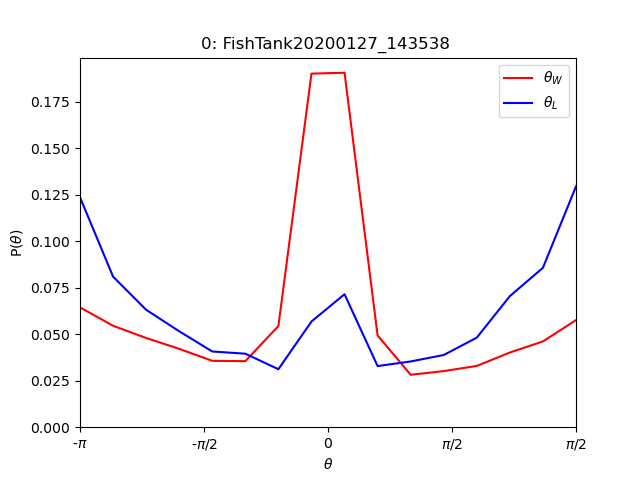

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
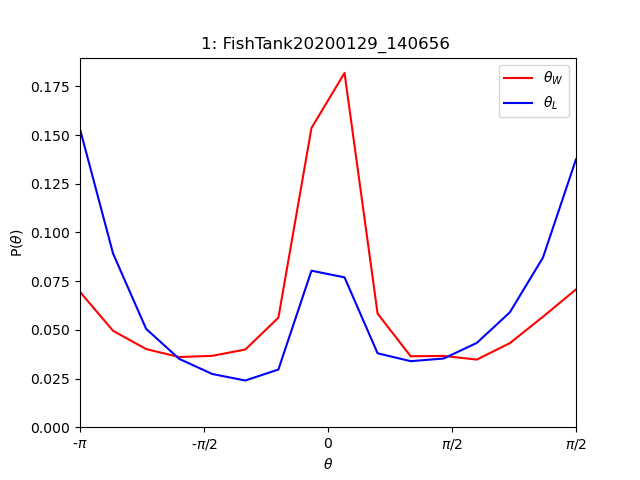

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
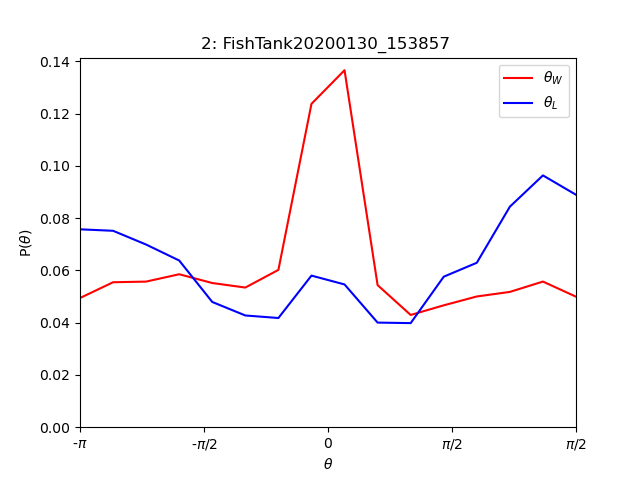

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
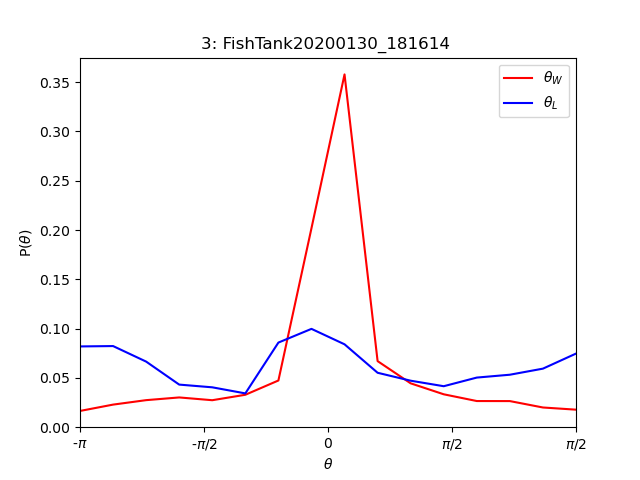

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
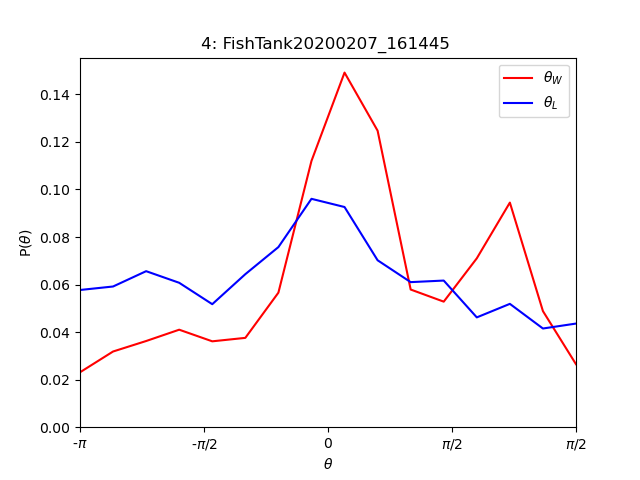

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
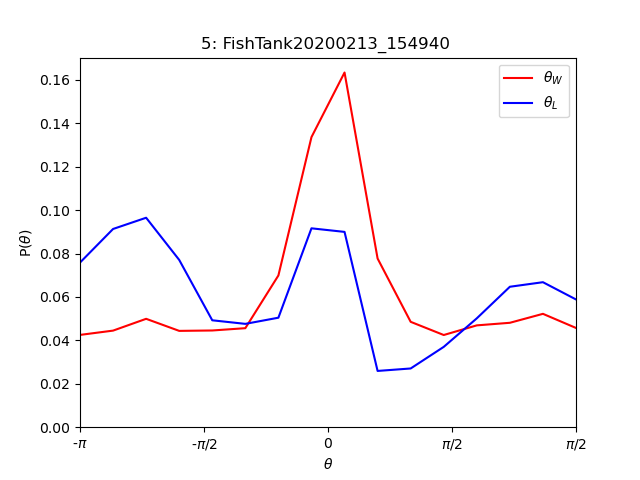

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
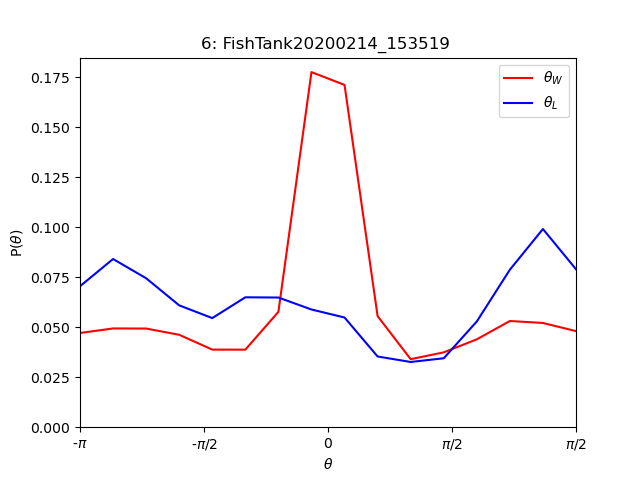

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
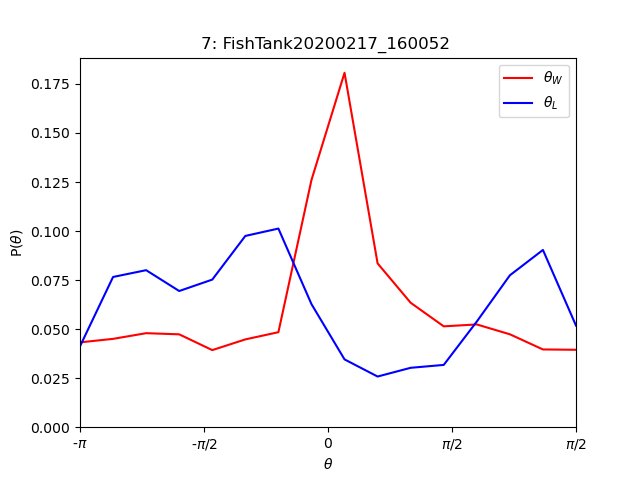

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
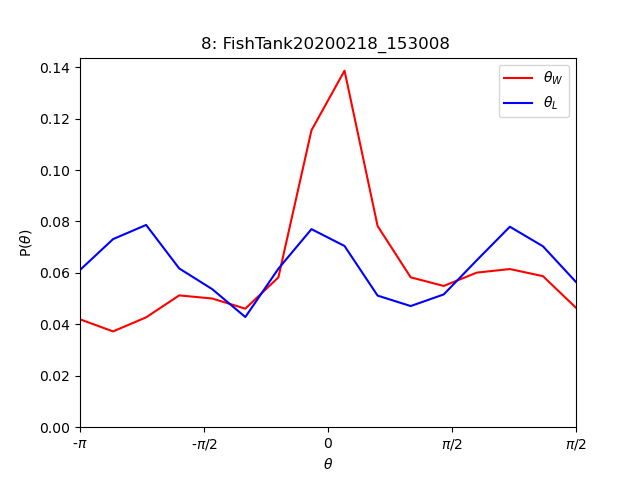

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
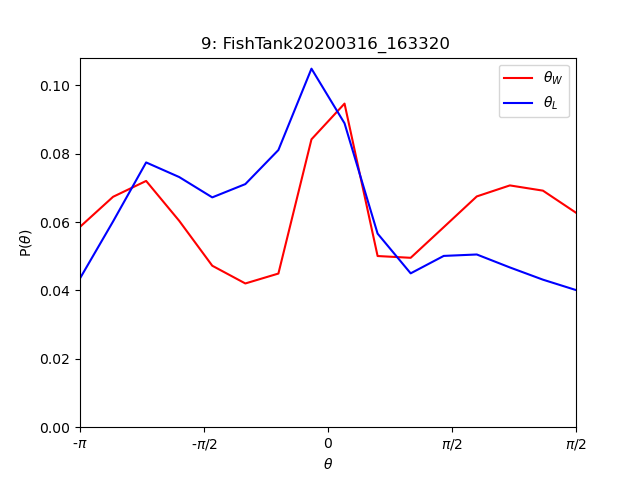

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
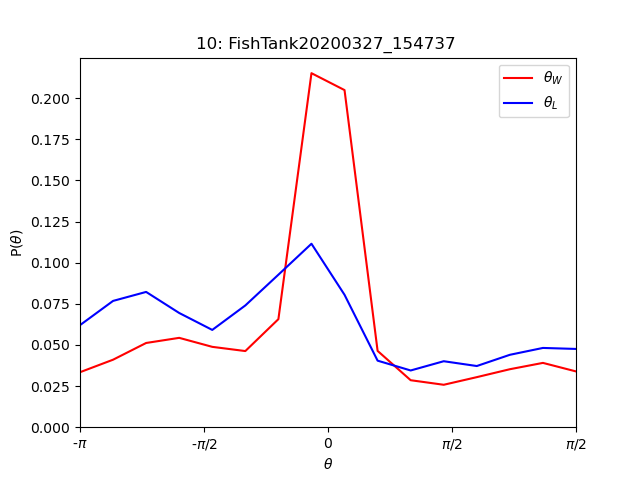

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
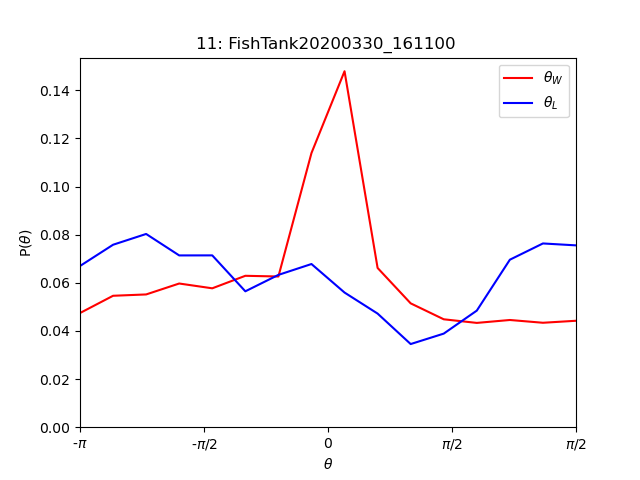

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
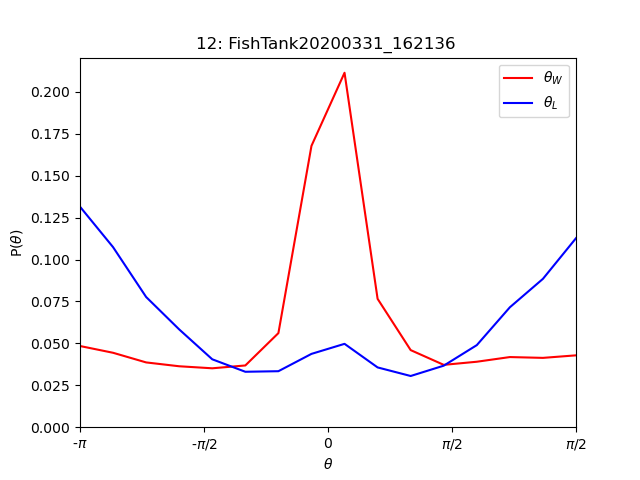

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
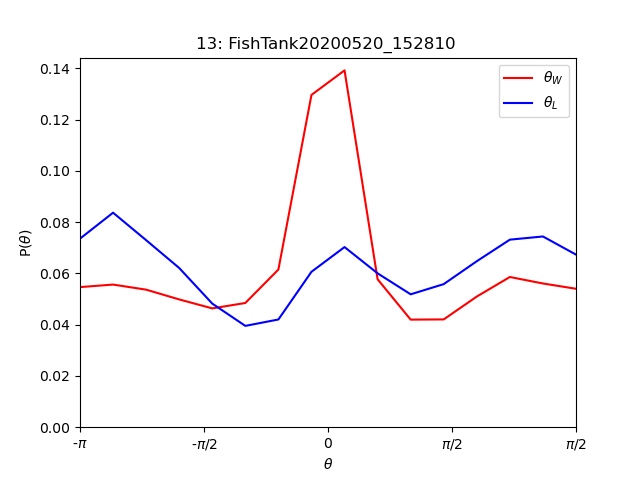

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
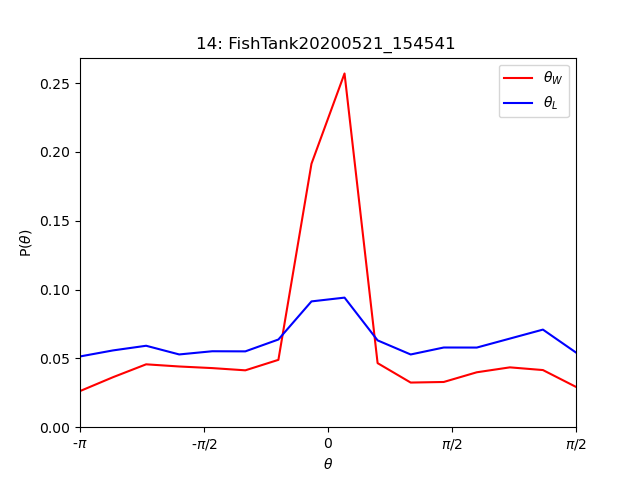

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
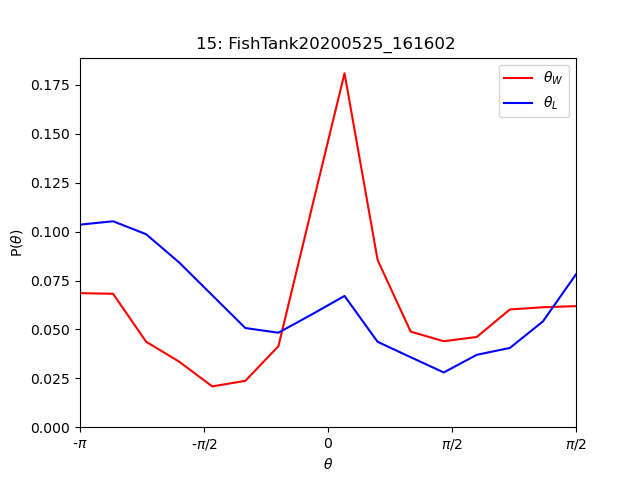

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
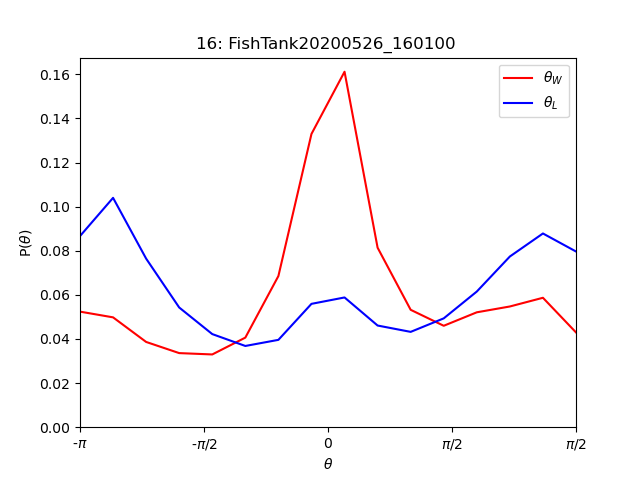

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
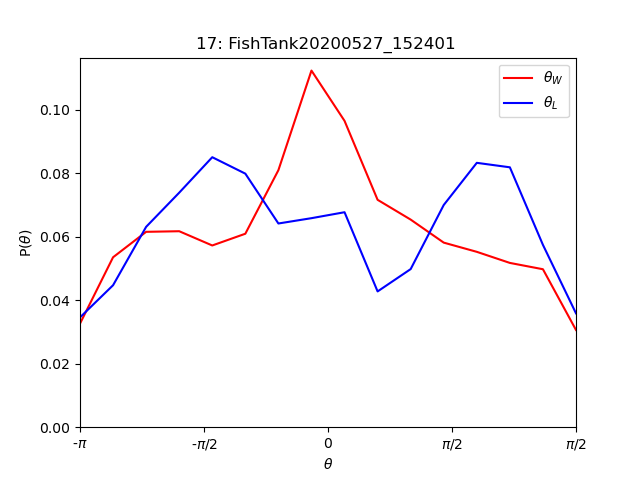

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
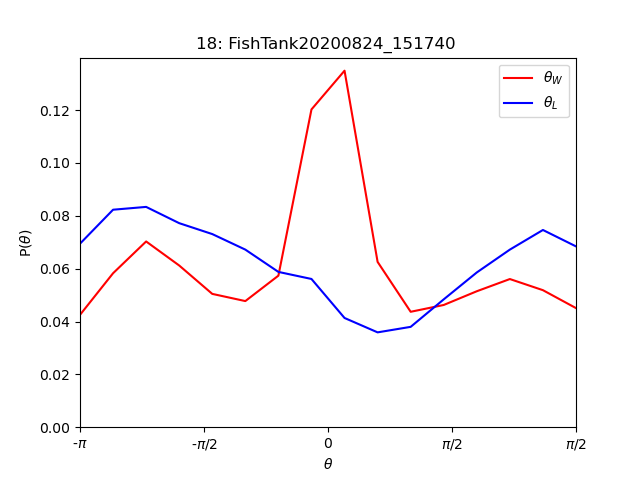

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
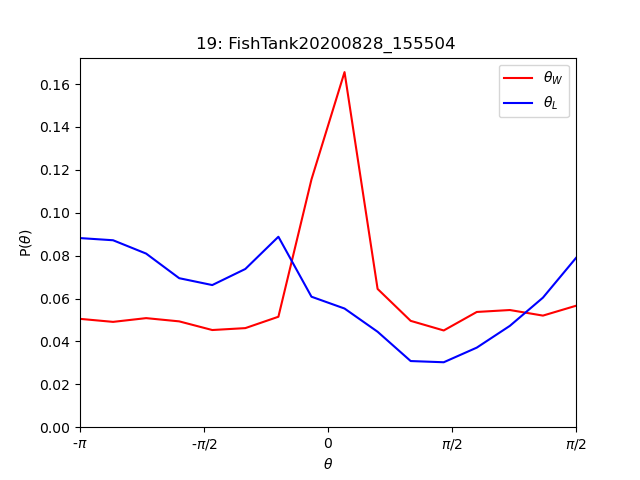

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
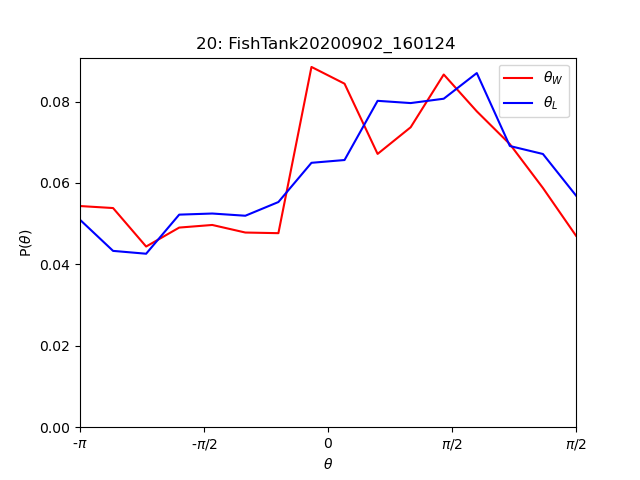

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
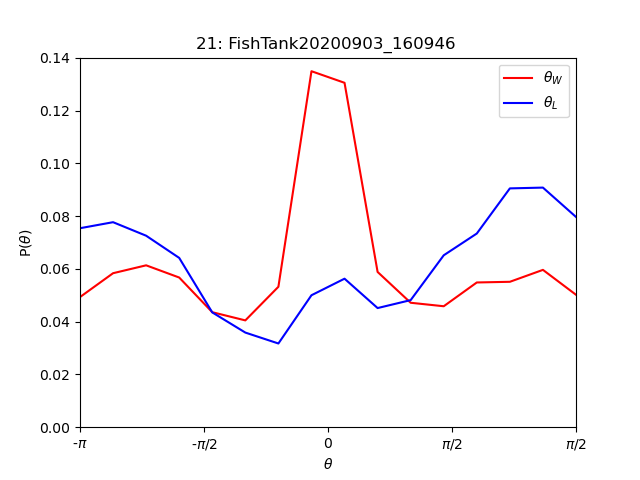

In [35]:
# now plot all of these distributions

# NB: the xtick labels are rough - binedges VS bincenters issue
    
for expIdx, expName in enumerate(expNames):
    print(expIdx)
    
    fig, ax = plt.subplots()
    
    #ax.set_title(expNames[expIdx])
    ax.set_title(f'{expIdx}: {expNames[expIdx]} ')
    
    ax.plot(exp_postfights_theta1_dists_list[expIdx], color='red', label=r'$\theta_{W}$')
    ax.plot(exp_postfights_theta2_dists_list[expIdx], color='blue', label=r'$\theta_{L}$')
    
    max_val = exp_postfights_theta1_dists_list[expIdx].shape[0] - 1
    xticks = [0, max_val*0.25, max_val*0.5, max_val*.75, max_val]
    ax.set_xticks(xticks)
    xticklabels = [r'-$\pi$', r'-$\pi/2$', '0', r'$\pi/2$', r'$\pi/2$']
    ax.set_xticklabels(xticklabels)
    ax.set_xlim(xticks[0], xticks[-1])
    ax.set_xlabel(r'$\theta$')
    
    ax.set_ylabel(r'P($\theta$)')
    ax.set_ylim(bottom=0)
    
    ax.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
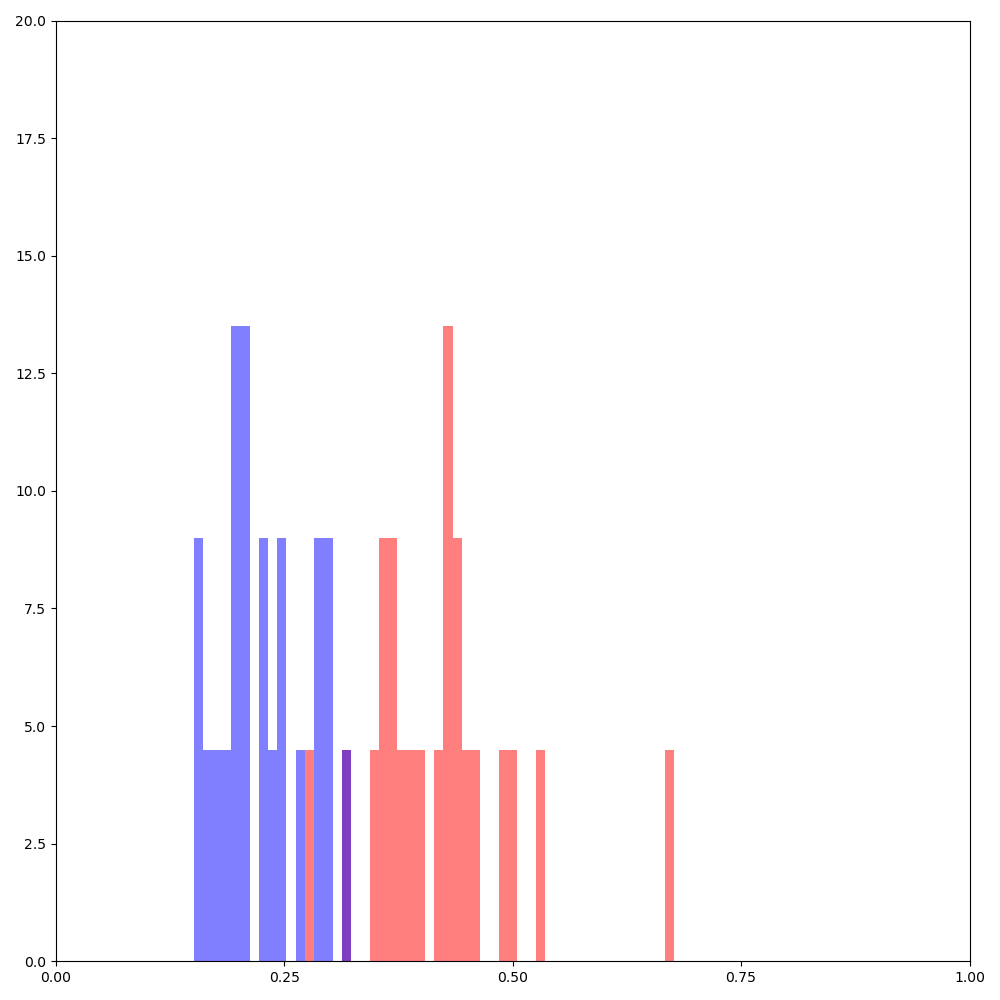

In [102]:
fig, axs = plt.subplots(figsize=(10,10))
ax = axs


tet1_hist = ax.hist(tet1_attack_probs, bins=np.linspace(0,1,100), label='tetW', color='red', alpha=0.5, density=True)
tet2_hist = ax.hist(tet2_attack_probs, bins=np.linspace(0,1,100), label='tetL', color='blue', alpha=0.5, density=True)

ax.set_xlim(0,1)
ax.set_xticks([i*0.25 for i in range(5)])

ax.set_ylim(0, 20)

fig.tight_layout()

In [103]:
np.argmin(tet1_attack_probs)

9

In [104]:
np.argmax(tet2_attack_probs)

4

In [30]:
# we say 9 and 4 do not have clear winners
no_clear_winner_idxs = [4,9]

In [41]:
[expNames[i] for i in no_clear_winner_idxs]

['FishTank20200207_161445', 'FishTank20200316_163320']

In [31]:
conclusive_winner_loser = [1 for i in range(len(expNames))]
conclusive_winner_loser[4] = 0
conclusive_winner_loser[9] = 0

conclusive_winner_loser

[1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

# Plot a histogram of winner and loser theta=0 peaks

In [32]:
# ------- get theta1 and theta2 for each of these post fight regions ---------#

exp_postfights_theta1_dists_list = []
exp_postfights_theta2_dists_list = []
used_expIdxs = []


for expIdx, expName in enumerate(expNames):
    print(expIdx)
    
    # plot without the problem experiments
    if expIdx in no_clear_winner_idxs:
        continue
    else:
        used_expIdxs.append(expIdx)
    
    f0 = int(exp_lastfight_to_end_dict[expName][0])
    fE = int(exp_lastfight_to_end_dict[expName][1])
    
    theta_1 = exp_tetWs[expIdx]
    theta_2 = exp_tetLs[expIdx]
        
    # parse down the data we want, stop frame until the end
    theta_1_to_end = theta_1[f0:fE]
    theta_2_to_end = theta_2[f0:fE]
    
    # now get the distributions of this data
    theta_1_to_end_counts, _ = np.histogram(theta_1_to_end, bins=theta_spatial_bins, density=True)
    theta_1_to_end_prob = theta_1_to_end_counts / np.sum(theta_1_to_end_counts)
    
    theta_2_to_end_counts, _ = np.histogram(theta_2_to_end, bins=theta_spatial_bins, density=True)
    theta_2_to_end_prob = theta_2_to_end_counts / np.sum(theta_2_to_end_counts)
    
    # record
    exp_postfights_theta1_dists_list.append(theta_1_to_end_prob)
    exp_postfights_theta2_dists_list.append(theta_2_to_end_prob)
    
    
    
    
# ---- now gather the peak probabilities ---- #

tet1_attack_probs_list = []
tet2_attack_probs_list = []

for ii in range(len(exp_postfights_theta1_dists_list)):
    
    tet1_attack_probs = np.sum(exp_postfights_theta1_dists_list[ii][7:11]) 
    tet2_attack_probs = np.sum(exp_postfights_theta2_dists_list[ii][7:11]) 
    
    tet1_attack_probs_list.append(tet1_attack_probs)
    tet2_attack_probs_list.append(tet2_attack_probs)
    
tet1_attack_probs = np.array(tet1_attack_probs_list)
tet2_attack_probs = np.array(tet2_attack_probs_list)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
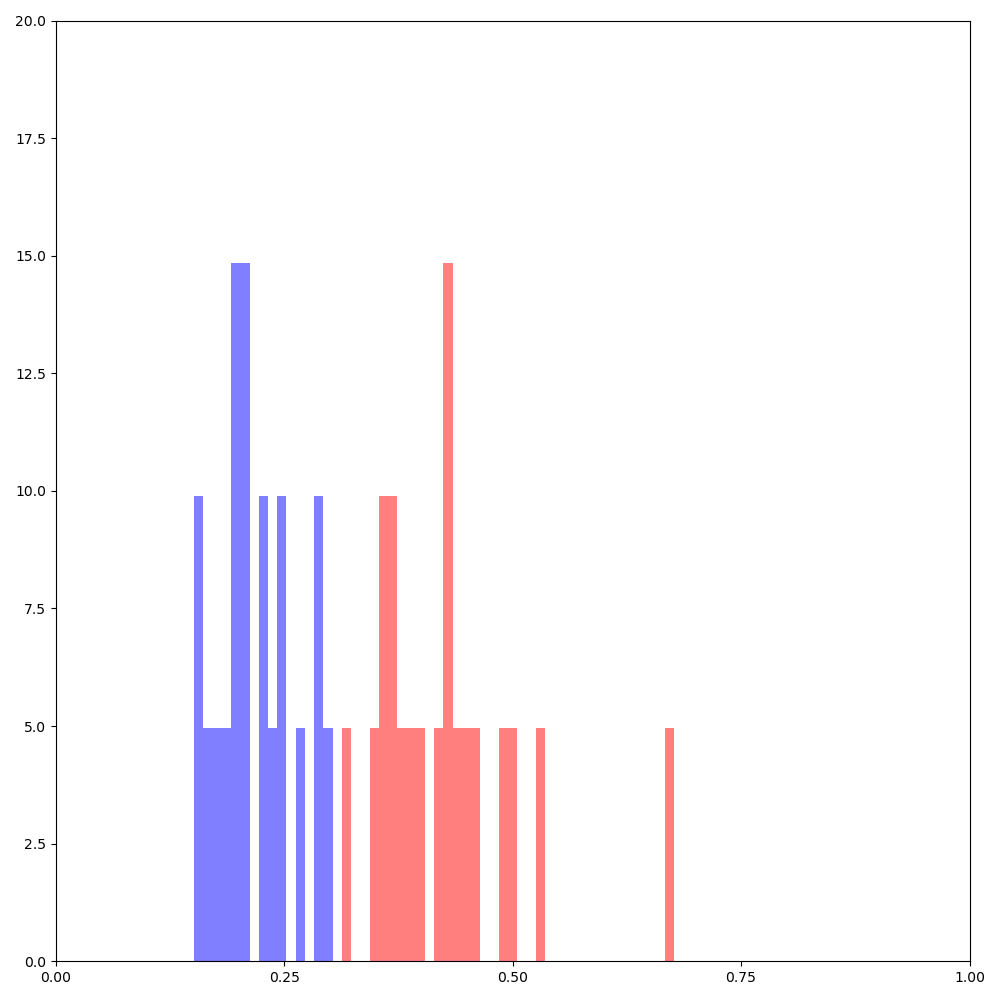

In [111]:
fig, axs = plt.subplots(figsize=(10,10))
ax = axs


tet1_hist = ax.hist(tet1_attack_probs, bins=np.linspace(0,1,100), label='tetW', color='red', alpha=0.5, density=True)
tet2_hist = ax.hist(tet2_attack_probs, bins=np.linspace(0,1,100), label='tetL', color='blue', alpha=0.5, density=True)

ax.set_xlim(0,1)
ax.set_xticks([i*0.25 for i in range(5)])

ax.set_ylim(0, 20)

fig.tight_layout()

In [112]:
len(used_expIdxs)

20

In [113]:
len(tet1_attack_probs)

20

In [114]:
tet1_attack_probs - tet2_attack_probs

array([0.26172117, 0.20107288, 0.16520291, 0.38495979, 0.18869388,
       0.25655517, 0.30023065, 0.14487066, 0.22806669, 0.17394934,
       0.34214097, 0.12570748, 0.2259106 , 0.22253105, 0.22472003,
       0.11973191, 0.19013201, 0.20360367, 0.02331893, 0.17180883])

## paper version of the figure

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
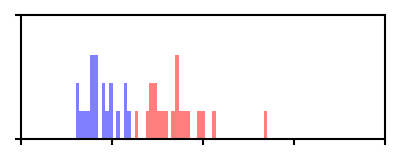

In [116]:
fig, axs = plt.subplots(figsize=(4,1.6))
ax = axs


tet1_hist = ax.hist(tet1_attack_probs, bins=np.linspace(0,1,100), label='         ', color='red', density=True, alpha=0.5)
tet2_hist = ax.hist(tet2_attack_probs, bins=np.linspace(0,1,100), label='         ', color='blue',density=True, alpha=0.5)

ax.set_xlim(0,1)
ax.set_xticks([i*0.25 for i in range(5)])

ax.set_ylim(0, 22)
ax.set_yticks([0, 22])

ax.set_xticklabels([])
ax.set_yticklabels([])

ax.xaxis.set_tick_params(width=1.5, length=4)
ax.yaxis.set_tick_params(width=1.5, length=4)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)
#ax.legend(fontsize=16, frameon=False, labelspacing=3, bbox_to_anchor=(0.9,0.9)) #
fig.tight_layout()


fig.savefig('/home/liam/temp/image_transfer/SI_winnersLosers.png', dpi=300, transparent=True)

In [84]:
# convert ytick max for density to probability (factor of bin_width conversion)

In [119]:
bins_width = tet1_hist[1][1] - tet1_hist[1][0]
bins_width

0.010101010101010102

In [ ]:
22*bins_width